<a href="https://colab.research.google.com/github/Dua-Sharif/Machine-Learning/blob/main/AI22303_(Lab_05).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import itertools

In [21]:
dataset = pd.read_csv('//content/Loan_dataset.csv', nrows=10)
dataset.head()

,person_age,male,person_education,person_income,loan_amnt,loan_intent,loan_int_rate,cb_person_cred_hist_length,previous_loan_defaults_on_file,loan_status
0,22,0,Master,71948,35000,PERSONAL,16.02,3,0,1
1,21,0,High School,12282,1000,EDUCATION,11.14,2,1,0
2,25,0,High School,12438,5500,MEDICAL,12.87,3,0,1
3,23,0,Bachelor,79753,35000,MEDICAL,15.23,2,0,1
4,24,1,Master,66135,35000,MEDICAL,14.27,4,0,1


In [22]:
def gini_impurity(y):
    """Calculates the Gini impurity of a set of labels."""
    if isinstance(y, pd.Series):
        unique, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities**2)
        return gini
    else:
        raise('Object must be a Pandas Series.')
gini_impurity(dataset.male)

0.17999999999999994

In [23]:
def variance(y):
  if(len(y) == 1):
    return 0
  else:
    return y.var()
def information_gain(y, mask, func=gini_impurity):
  a = sum(mask)
  b = mask.shape[0] - a

  if(a == 0 or b ==0):
    gain = 0
  else:
    if y.dtypes != 'O':
      gain = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
    else:
      gain = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])

  return gain

In [24]:
information_gain(dataset['loan_status'], dataset['male'] == 1)

-2.7755575615628914e-17

In [25]:
def categorical_options(a):
  #Creates all possible combinations from a Pandas Series.

  a = a.unique()

  opciones = []
  for L in range(0, len(a)+1):
      for subset in itertools.combinations(a, L):
          subset = list(subset)
          opciones.append(subset)

  return opciones[1:-1]

def max_information_gain_split(x, y, func=gini_impurity):

  split_value = []
  gain = []

  numeric_variable = True if x.dtypes != 'O' else False

  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else:
    options = categorical_options(x)

  # Calculate gain for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_gain = information_gain(y, mask, func)
    # Append results
    gain.append(val_gain)
    split_value.append(val)

  if len(gain) == 0:
    return(None,None,None,False)

  else:
    best_gain = max(gain)
    best_gain_index = gain.index(best_gain)
    best_split = split_value[best_gain_index]
    return(best_gain,best_split,numeric_variable, True)

age_gain, age_split, _, _ = max_information_gain_split(dataset['person_age'], dataset['loan_status'],)

print(
  "The best split for Age is when the variable is less than ",
  age_split,"\nInformation Gain for that split is:", age_gain)

The best split for Age is when the variable is less than  22 
Information Gain for that split is: 1.3877787807814457e-17


In [26]:
dataset.drop('loan_status', axis= 1).apply(max_information_gain_split, y = dataset['loan_status'])

,person_age,male,person_education,person_income,loan_amnt,loan_intent,loan_int_rate,cb_person_cred_hist_length,previous_loan_defaults_on_file
0,0.0,-0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.1
1,22,1,[Master],12438,1600,[PERSONAL],11.11,3,1
2,True,True,False,True,True,False,True,True,True
3,True,True,True,True,True,True,True,True,True


In [27]:
def get_best_split(y, dataset):
  masks = dataset.drop(y, axis= 1).apply(max_information_gain_split, y = dataset[y], func=gini_impurity)
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)

  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = masks.iloc[0].astype(np.float32).idxmax()
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1]
    split_gain = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_ig, split_numeric)


def make_split(variable, value, dataset, is_numeric):
  if is_numeric:
    dataset_1 = dataset[dataset[variable] < value]
    dataset_2 = dataset[(dataset[variable] < value) == False]
  else:
    dataset_1 = dataset[dataset[variable].isin(value)]
    dataset_2 = dataset[(dataset[variable].isin(value)) == False]

  return(dataset_1,dataset_2)


def make_prediction(dataset, target_factor):
  if target_factor:
    pred = dataset.value_counts().idxmax()
  else:
    pred = dataset.mean()

  return pred

In [29]:
def train_tree(dataset, y, target_factor, max_depth=None, min_samples_split=None, min_information_gain=1e-5, counter=0, max_categories=20):
    if counter == 0:
        types = dataset.dtypes
        for column in types[types == "object"].index:
            if len(dataset[column].value_counts()) > max_categories:
                raise ValueError(f'Variable {column} has more than {max_categories} unique values.')
    if max_depth is None or counter < max_depth:
        if min_samples_split is None or dataset.shape[0] > min_samples_split:
            var, val, gain, var_type = get_best_split(y, dataset)
            if gain is not None and gain >= min_information_gain:
                counter += 1
                left, right = make_split(var, val, dataset, var_type)
                question = f"{var} {'<=' if var_type else 'in'} {val}"
                subtree = {question: [train_tree(left, y, target_factor, max_depth, min_samples_split, min_information_gain, counter),
                                      train_tree(right, y, target_factor, max_depth, min_samples_split, min_information_gain, counter)]}
                return subtree if subtree[question][0] != subtree[question][1] else subtree[question][0]
    return make_prediction(dataset[y], target_factor)


In [31]:
def classify_data(observation, tree):
    question = list(tree.keys())[0]
    if question.split()[1] == '<=':
        answer = tree[question][0] if observation[question.split()[0]] <= float(question.split()[2]) else tree[question][1]
    else:
        answer = tree[question][0] if observation[question.split()[0]] in eval(question.split()[2]) else tree[question][1]
    return answer if not isinstance(answer, dict) else classify_data(observation, answer)


Employ SciKit Learn implementation of decision tree and plot it. Observe for any difference(s).

In [32]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [33]:
X = dataset.drop('loan_status', axis=1)
y = dataset['loan_status']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = X.select_dtypes(include=['object']).columns
encoded_data = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

In [34]:
X = X.drop(categorical_features, axis=1)
X = pd.concat([X, encoded_df], axis=1)

# Now split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [36]:
y_pred_gini = dt_gini.predict(X_test)
print(f"Scikit-learn Decision Tree Accuracy: {accuracy_score(y_test, y_pred_gini):.3f}")

Scikit-learn Decision Tree Accuracy: 0.667


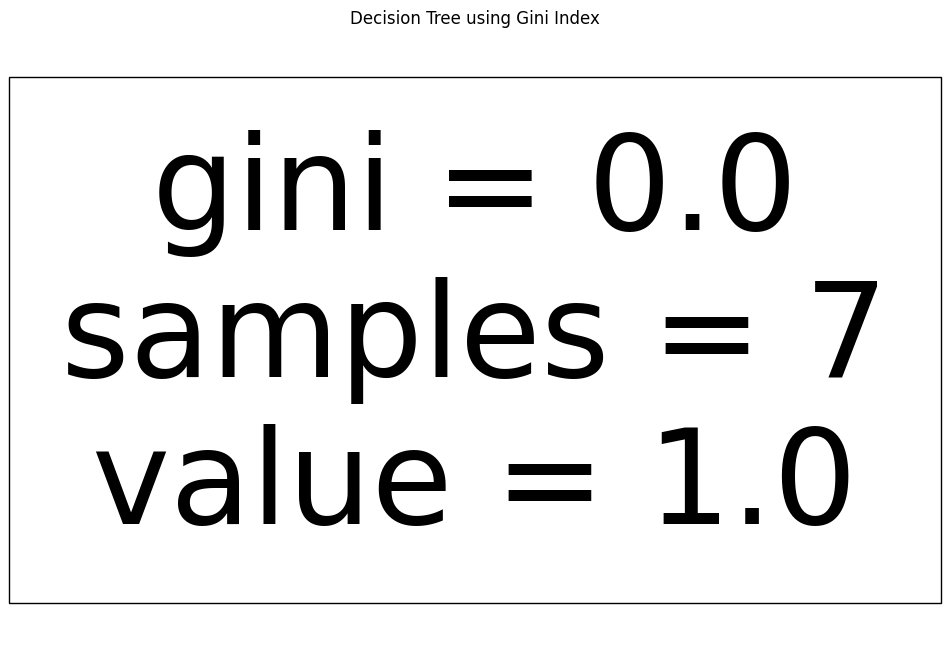

In [42]:
plt.figure(figsize=(12, 8))
plot_tree(dt_gini, filled=True, feature_names=X.columns, class_names=y.unique().astype(str))
plt.title("Decision Tree using Gini Index")
plt.show()
